# Pendulum

In [1]:
'''TODO
''';

In [2]:
import time
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter
from torch.optim.lr_scheduler import StepLR
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

%matplotlib inline

In [3]:
# use cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used: " + str(DEVICE))

Device used: cuda


Parameters and datasets were taken from the experiments of the paper "Deep learning for universal linear embeddings of nonlinear dynamics"


### Parameters

In [4]:
# datasets path
DATA_PATH = './data/'

# parameters related to datasets
LEN_TIME = 51
SYSTEM_DIM = 2  # dimension of input
DELTA_t = 0.02

# parameters of the loss
ALPHA1 = 1e-3
ALPHA2 = 1e-1
ALPHA_L2 = 1e-14
PRED_WEIGHT = torch.tensor(np.array([1/(1+0.01*i) for i in range(LEN_TIME)]), requires_grad=False, device=DEVICE)

# training parameters
BATCH_SIZE = 128
HIDDEN_DIM = 64
LATENT_DIM = 256
LR = 1e-4


### Load dataset

In [5]:
class CustomDataset(Dataset):
    '''
    Create the dataset from the trajectories contained in file_path
    '''
    def __init__(self, file_path, len_trajectory, system_dim):
        dataset = pd.read_csv(file_path, header=None)
        try:
            self.data = np.array(dataset).reshape((-1,len_trajectory,system_dim))
            self.targets = np.array(dataset).reshape((-1,len_trajectory,system_dim))
        except KeyError as e:
            print(e)
            return None
        else:
            print(f"Extracted {self.data.shape} data along with {self.targets.shape} targets")
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input = self.data[idx]
        output = self.targets[idx]
        return input, output

In [6]:
'''
# This cell concatenated the separated training datasets into one

train_data1 = pd.read_csv(DATA_PATH + 'Pendulum_train1_x.csv', header=None)
train_data2 = pd.read_csv(DATA_PATH + 'Pendulum_train2_x.csv', header=None)
train_data3 = pd.read_csv(DATA_PATH + 'Pendulum_train3_x.csv', header=None)
train_data4 = pd.read_csv(DATA_PATH + 'Pendulum_train4_x.csv', header=None)
train_data5 = pd.read_csv(DATA_PATH + 'Pendulum_train5_x.csv', header=None)
train_data6 = pd.read_csv(DATA_PATH + 'Pendulum_train6_x.csv', header=None)
train_data = pd.concat((train_data1, train_data2, train_data3, train_data4, train_data5, train_data6))
train_data.to_csv(DATA_PATH + 'Pendulum_train_x.csv', header=False, index=False)
''';

In [7]:
train_dataset = CustomDataset(DATA_PATH + 'Pendulum_train_x.csv', LEN_TIME, SYSTEM_DIM)
val_dataset = CustomDataset(DATA_PATH + 'Pendulum_val_x.csv', LEN_TIME, SYSTEM_DIM)
test_dataset = CustomDataset(DATA_PATH + 'Pendulum_test_x.csv', LEN_TIME, SYSTEM_DIM)

Extracted (21000, 51, 2) data along with (21000, 51, 2) targets
Extracted (1000, 51, 2) data along with (1000, 51, 2) targets
Extracted (500, 51, 2) data along with (500, 51, 2) targets


In [8]:
train_data = train_dataset.data
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
)

val_data = val_dataset.data
val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
)

test_data = test_dataset.data
test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
)

In [15]:
class KoopmanNet(nn.Module):
    '''
    Koopman network that encodes, advances in time and decodes
    
    params:
        system_dim -- initial system dimension
        hidden -- number of hidden units in each layer of the encoder and decoder
        latent_dim -- dimension of the approximated invariant Koopman subspace
    '''
    def __init__(self, system_dim, hidden, latent_dim):
        super(KoopmanNet, self).__init__()
                
        self.encode = nn.Sequential(
            nn.Linear(system_dim, hidden),
            nn.ELU(),
            nn.Linear(hidden, hidden),
            nn.ELU(),
            nn.Linear(hidden, latent_dim),
        )
        
        self.L = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ELU(),
            nn.Linear(hidden, hidden),
            nn.ELU(),
            nn.Linear(hidden, system_dim),
        )
        
    def forward(self, x):
        y = self.encode(x)
        x_recon = self.decode(y)
                
        y_lin = y[:,0,:].unsqueeze(dim=1)
        for i in range(x.shape[1]-1):
            y_prev = y_lin[:,-1,:].unsqueeze(dim=1)
            y_lin = torch.cat((y_lin, self.L(y_prev)), dim=1)
            
        x_pred = self.decode(y_lin)

        return x, x_recon, x_pred, y, y_lin

In [16]:
def define_loss(x, x_recon, x_pred, y, y_lin, target, alpha1, alpha2):
    
    # reconstruction loss
    recon_loss = alpha1 * F.mse_loss(x_recon, x)
    
    # linearity loss
    lin_loss = torch.tensor(0)
    lin_loss = F.mse_loss(y, y_lin)
    
    # prediction loss
    pred_loss = torch.tensor(0)
    #pred_loss = torch.mean(PRED_WEIGHT*torch.linalg.norm(x_pred-x, dim=2)**2) # weighted MSE
    pred_loss = alpha2*F.mse_loss(x, x_pred)
    
    # total loss
    loss = recon_loss + pred_loss + lin_loss
    
    return loss, recon_loss, lin_loss, pred_loss

In [17]:
def eval_model(model, dataloader):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(DEVICE).float(), target.to(DEVICE).float()
            x, x_recon, x_pred, y, y_lin = model(data)
            loss, recon_loss, lin_loss, pred_loss = define_loss(x, x_recon, x_pred, y, y_lin, 
                                                                target, ALPHA1, ALPHA2)
            total_loss += loss.item()*data.size(0) # multiply by batch size
    
    return total_loss/len(dataloader) # divide by number of batches


### Training

In [19]:
model = KoopmanNet(system_dim=SYSTEM_DIM, hidden=HIDDEN_DIM,
                   latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=ALPHA_L2)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


In [20]:
loss_epochs = []
recon_loss_epochs = []
lin_loss_epochs = []
pred_loss_epochs = []
val_loss = []

In [ ]:
%%time

nb_epochs = 500

for epoch in range(nb_epochs):
    
    if(epoch % 10 == 0):
        print('Epoch {}'.format(epoch))
        
    running_loss = 0
    running_recon_loss = 0
    running_lin_loss = 0
    running_pred_loss = 0
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(DEVICE).float(), target.to(DEVICE).float()
        # reset gradients
        optimizer.zero_grad()

        # forward, backward, optimize
        x, x_recon, x_pred, y, y_lin = model(data)
        loss, recon_loss, lin_loss, pred_loss = define_loss(x, x_recon, x_pred, y, y_lin, 
                                                            target, ALPHA1, ALPHA2)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()*data.size(0)
        running_recon_loss += recon_loss.item()*data.size(0)
        running_lin_loss += lin_loss.item()*data.size(0)
        running_pred_loss += pred_loss.item()*data.size(0)
        
    # store running losses
    with torch.no_grad():
        loss_epochs.append(running_loss/len(train_dataloader))
        recon_loss_epochs.append(running_recon_loss/len(train_dataloader))
        lin_loss_epochs.append(running_lin_loss/len(train_dataloader))
        pred_loss_epochs.append(running_pred_loss/len(train_dataloader))
        
    val_loss.append(eval_model(model, val_dataloader)) 
    
    if epoch < 200:
        scheduler.step()

### Plots

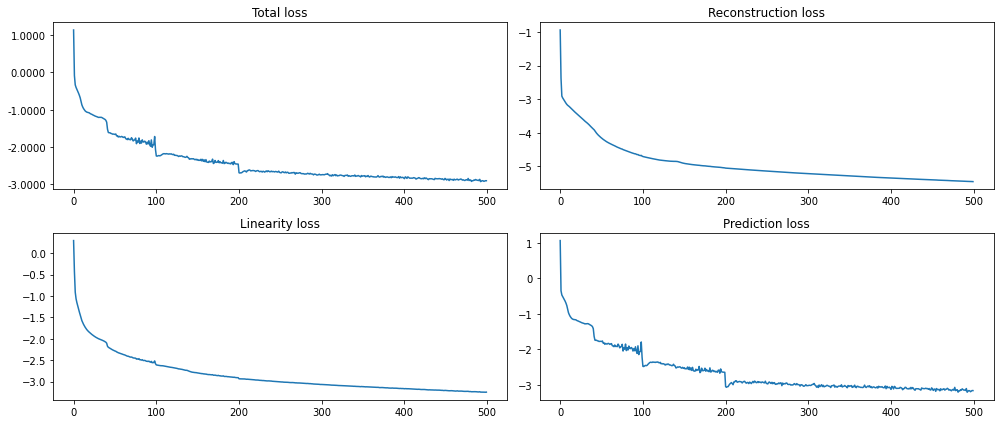

In [32]:
# plot training losses
fig, axes = plt.subplots(2, 2, figsize=(14,6))
axes[0, 0].plot(np.log10(loss_epochs))
axes[0, 0].set_title('Total loss')
#axes[0, 0].set_ylim(top=0)
axes[0, 1].plot(np.log10(recon_loss_epochs))
axes[0, 1].set_title('Reconstruction loss')
axes[1, 0].plot(np.log10(lin_loss_epochs))
axes[1, 0].set_title('Linearity loss')
#axes[1, 0].set_ylim(top=0)
axes[1, 1].plot(np.log10(pred_loss_epochs))
axes[1, 1].set_title('Prediction loss')

axes[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.tight_layout()
plt.savefig('./pendulum/saved/training_errors.jpg')
plt.show()

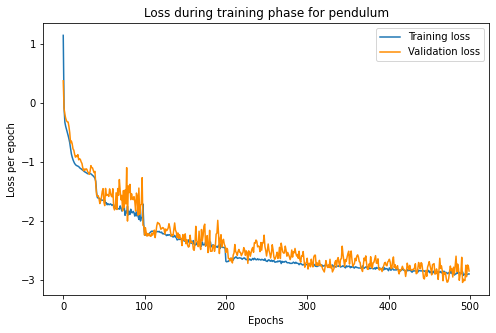

In [33]:
# plot loss
plt.subplots(figsize=(8,5))
plt.plot(np.log10(loss_epochs), label='Training loss')
plt.plot(np.log10(val_loss), color='darkorange', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss per epoch')
plt.title('Loss during training phase for pendulum')
plt.legend()
plt.savefig('./pendulum/saved/train_val_error.jpg')
plt.show()

### Model evaluation

In [34]:
training_error = eval_model(model, train_dataloader)
validation_error = eval_model(model, val_dataloader)

print(f'Log10 of training error:     {training_error:.12f}')
print(f'Log10 of validation error:   {validation_error:.12f}')

Log10 of training error:     0.001442141211
Log10 of validation error:   0.001411712762


### Trajectory simulation

In [35]:
# Load validation/test trajectories
with torch.no_grad():
    for data, target in val_dataloader:
        data, target = data.to(DEVICE).float(), target.to(DEVICE).float()

        output = model(data)
        x, x_recon, x_pred, y, y_lin = model(data)

In [36]:
x = np.array(x.detach().cpu())
x_recon = np.array(x_recon.detach().cpu())
x_pred = np.array(x_pred.detach().cpu())

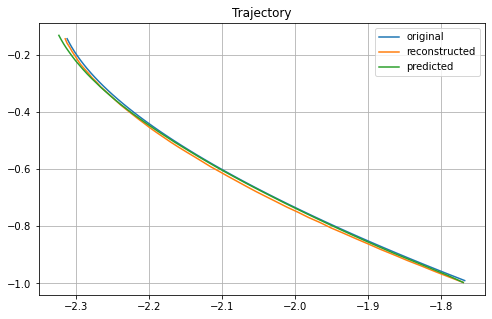

In [62]:
traj = 4
fig, ax =plt.subplots(figsize=(8,5))
plt.plot(x[traj,:,0], x[traj,:,1], label='original')
plt.plot(x_recon[traj,:,0], x_recon[traj,:,1], label='reconstructed')
plt.plot(x_pred[traj,:,0], x_pred[traj,:,1], label='predicted')
plt.title('Trajectory')
#ax.set_aspect('equal')
plt.grid()
plt.legend()
plt.savefig('./pendulum/saved/traj_example2.jpg')
plt.show()

In [42]:
PATH = './pendulum/saved/pendulum_model.pt'

In [43]:
torch.save(model.state_dict(), PATH)

In [38]:
model = KoopmanNet(system_dim=SYSTEM_DIM, hidden=HIDDEN_DIM,
                   latent_dim=LATENT_DIM).to(DEVICE)
model.load_state_dict(torch.load(PATH, map_location=DEVICE))

<All keys matched successfully>

In [44]:
np.save('./pendulum/saved/training_loss.npy', loss_epochs)
np.save('./pendulum/saved/recon_loss_epochs.npy', recon_loss_epochs)
np.save('./pendulum/saved/lin_loss_epochs.npy', lin_loss_epochs)
np.save('./pendulum/saved/pred_loss_epochs.npy', pred_loss_epochs)
np.save('./pendulum/saved/val_loss.npy', val_loss)